In [13]:
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")  # ignore warnings to clean up output cells

# set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# load "trigonometry" - dataset
trig = pd.read_csv("trigonometry.csv")

## **Fourier Features (trigonometry-dataset):**

- > *derived from the index of a time series* `trig.index`

- > *generate Fourier features for 'time-series'* `features {}`

- > *each columns in df corresponds to 'Fourier feature'*
`df.keys()`

In [16]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32) #time-vector, length=4831
    k = 2 * np.pi * (1 / freq) * time #angular freq. vector,  length=4831
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index), features

# compute "Fourier features" to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality
df, features= fourier_features(trig.index, freq=365.25, order=4)
df

,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634
2,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545
3,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769
4,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360
...,...,...,...,...,...,...,...,...
4826,0.972907,0.231196,0.449865,-0.893096,-0.764897,-0.644152,-0.803546,0.595242
4827,0.976740,0.214425,0.418875,-0.908044,-0.797106,-0.603839,-0.760714,0.649087
4828,0.980283,0.197597,0.387403,-0.921911,-0.827184,-0.561932,-0.714301,0.699838
4829,0.983538,0.180704,0.355458,-0.934692,-0.855076,-0.518502,-0.664488,0.747299


## **Seasonal & Periodogram Plot Function:**

In [5]:
# set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

#seasonal plot (df, df[target], seasonal_period, frequency, ax) -> ax
def seasonal_plot(X, y, period, freq, ax=None):
    #check if axis is provided
    if ax is None:
        _, ax = plt.subplots()
    #define color palette
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),) #husl: hue, saturation & lightness
    #create lineplot
    ax = sns.lineplot(
        x=freq, #x-axis
        y=y,    #df[target]
        hue=period,
        data=X,
        ci=False, #confidence interval
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    #annotation
    for line, name in zip(ax.lines, X[period].unique()): # ax.lines: list of Line2D objects, df[target]
        y_ = line.get_ydata()[-1] #extract last y-co-ordinate of last line for annotation
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

#periodogram plot -> identify dominant freq. & periodic patterns in time series data
#detrend = 'linear'  -> removes any linear trend
#plot_periodogram (df.target, detrendm ax) -> ax
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D") #diff. in timedelta
    #frequency component (corresponding to spectrum), psd of i/p time-series
    frequencies, spectrum = periodogram(
        ts, #i/p time-series -> df[target]
        fs=fs, #overall scale of o/p freq.
        detrend=detrend, #separate undelying trend from signal -> to focus on trend of interest, i.e., seasonality & irregular fluctuation
        window="boxcar", #uniform window -> no windowing is applied
        scaling='spectrum', #power spectrum density
    )
    if ax is None:
        _, ax = plt.subplots()
    #create step plot
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log") #x-axis: log scale
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104]) #specific location in x-axis where tick marks will be placed
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ], #(no.) indicates cycle/year
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0)) #1e4 notation on y-axis
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax, frequencies

#load tunnel dataframe -> target : 'NumVehicles'
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

In [6]:
# target
tunnel['NumVehicles']

Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
               ...  
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Freq: D, Name: NumVehicles, Length: 747, dtype: int64

## **Seasonal Plot ("tunnel"-dataframe):**

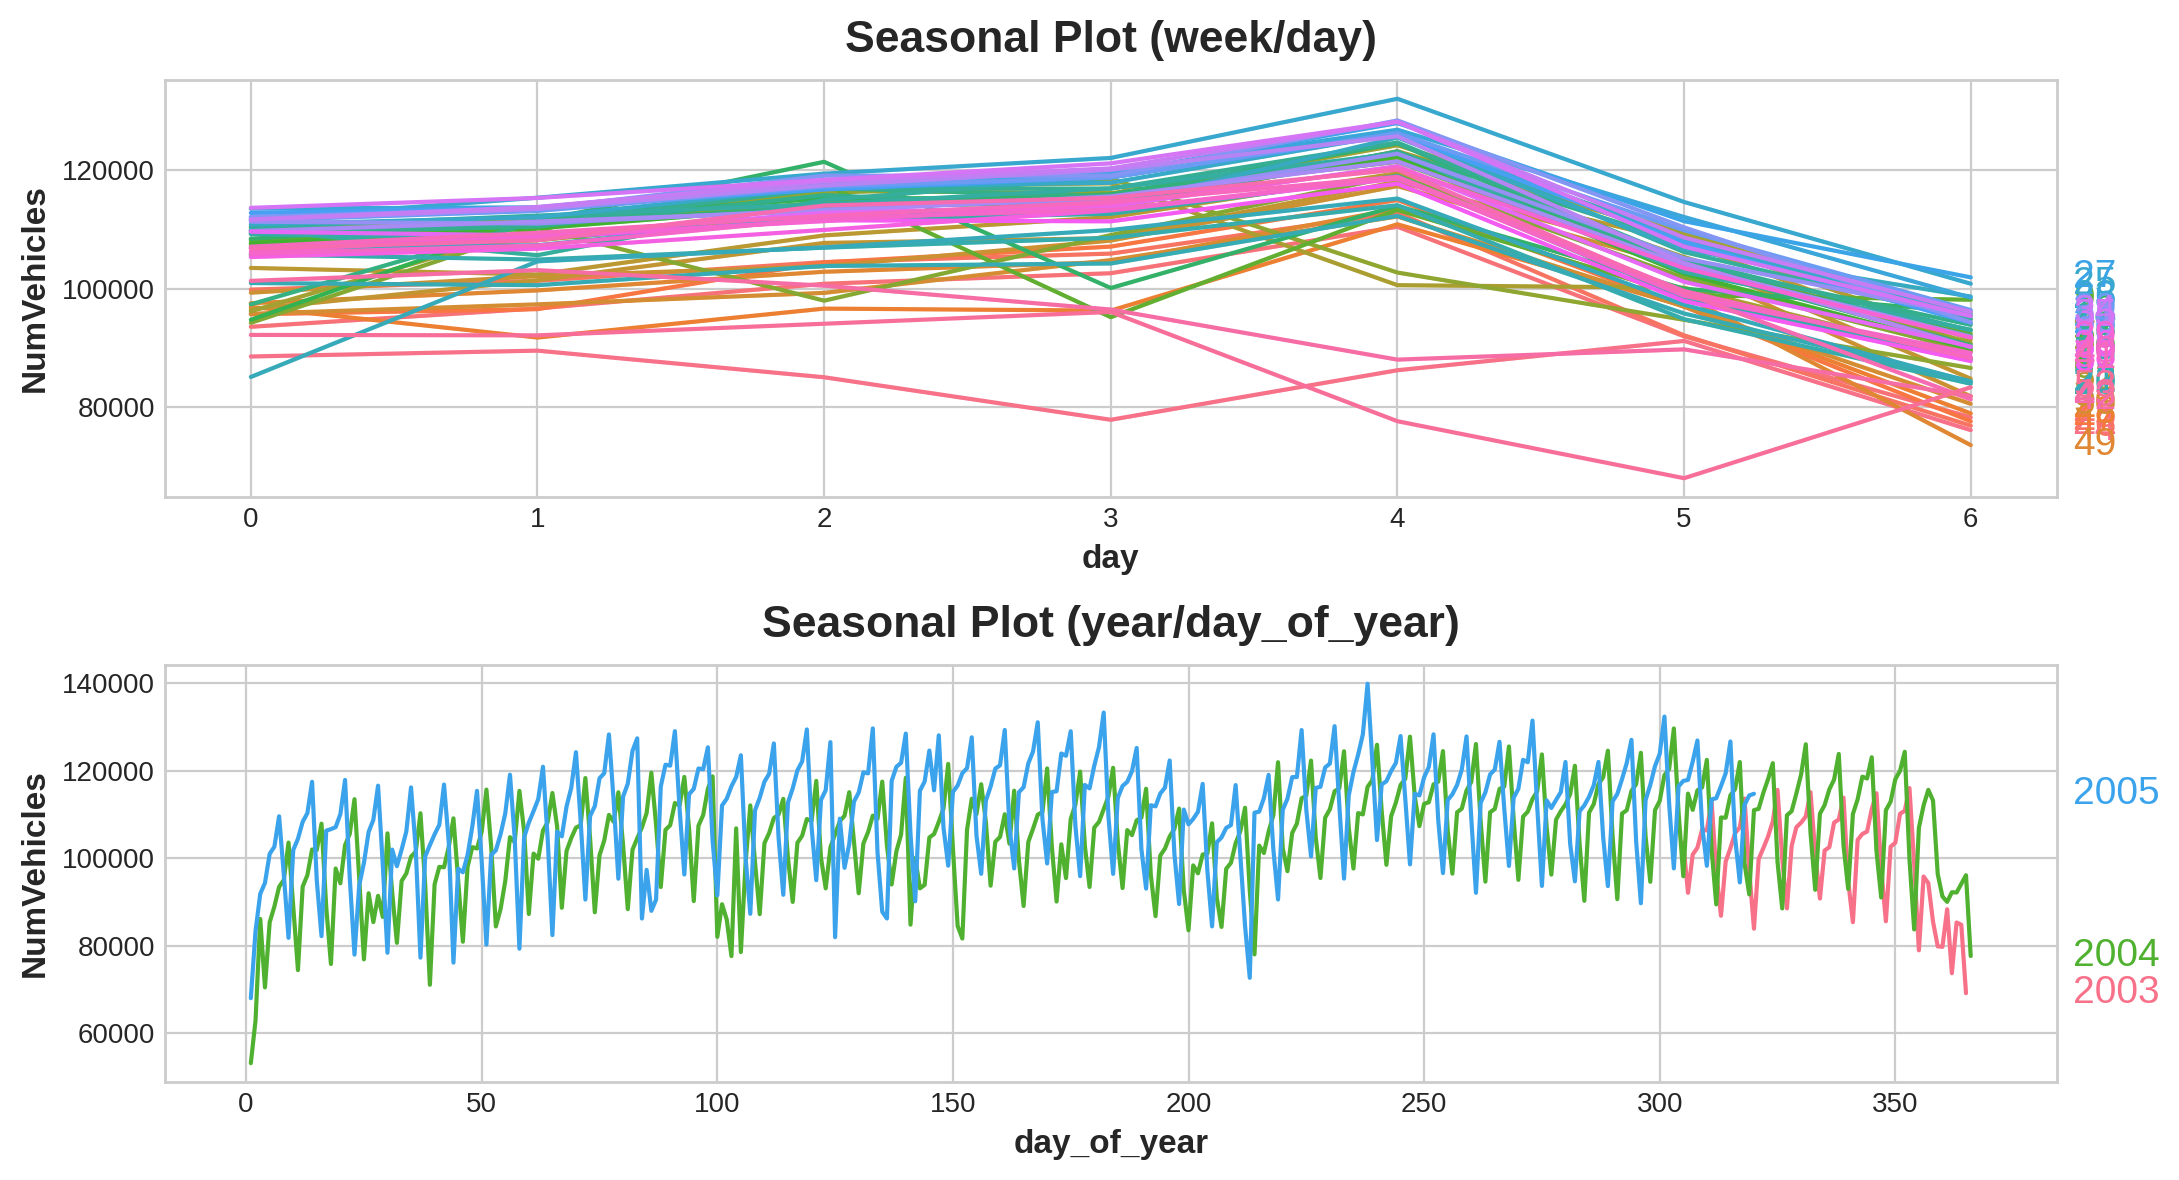

In [7]:
#df copy
X = tunnel.copy()

# days within a week, type: PeriodIndex, Monday:0 - Sunday:6
X["day"] = X.index.dayofweek
X["week"] = X.index.week  # week number for each index

# days within a year
X["day_of_year"] = X.index.dayofyear #day no. in year
X["year"] = X.index.year #year no.

#plot seasonal (week/day)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="day_of_year", ax=ax1)
plt.show()

## **Periodogram ("tunnel"-dataframe):**

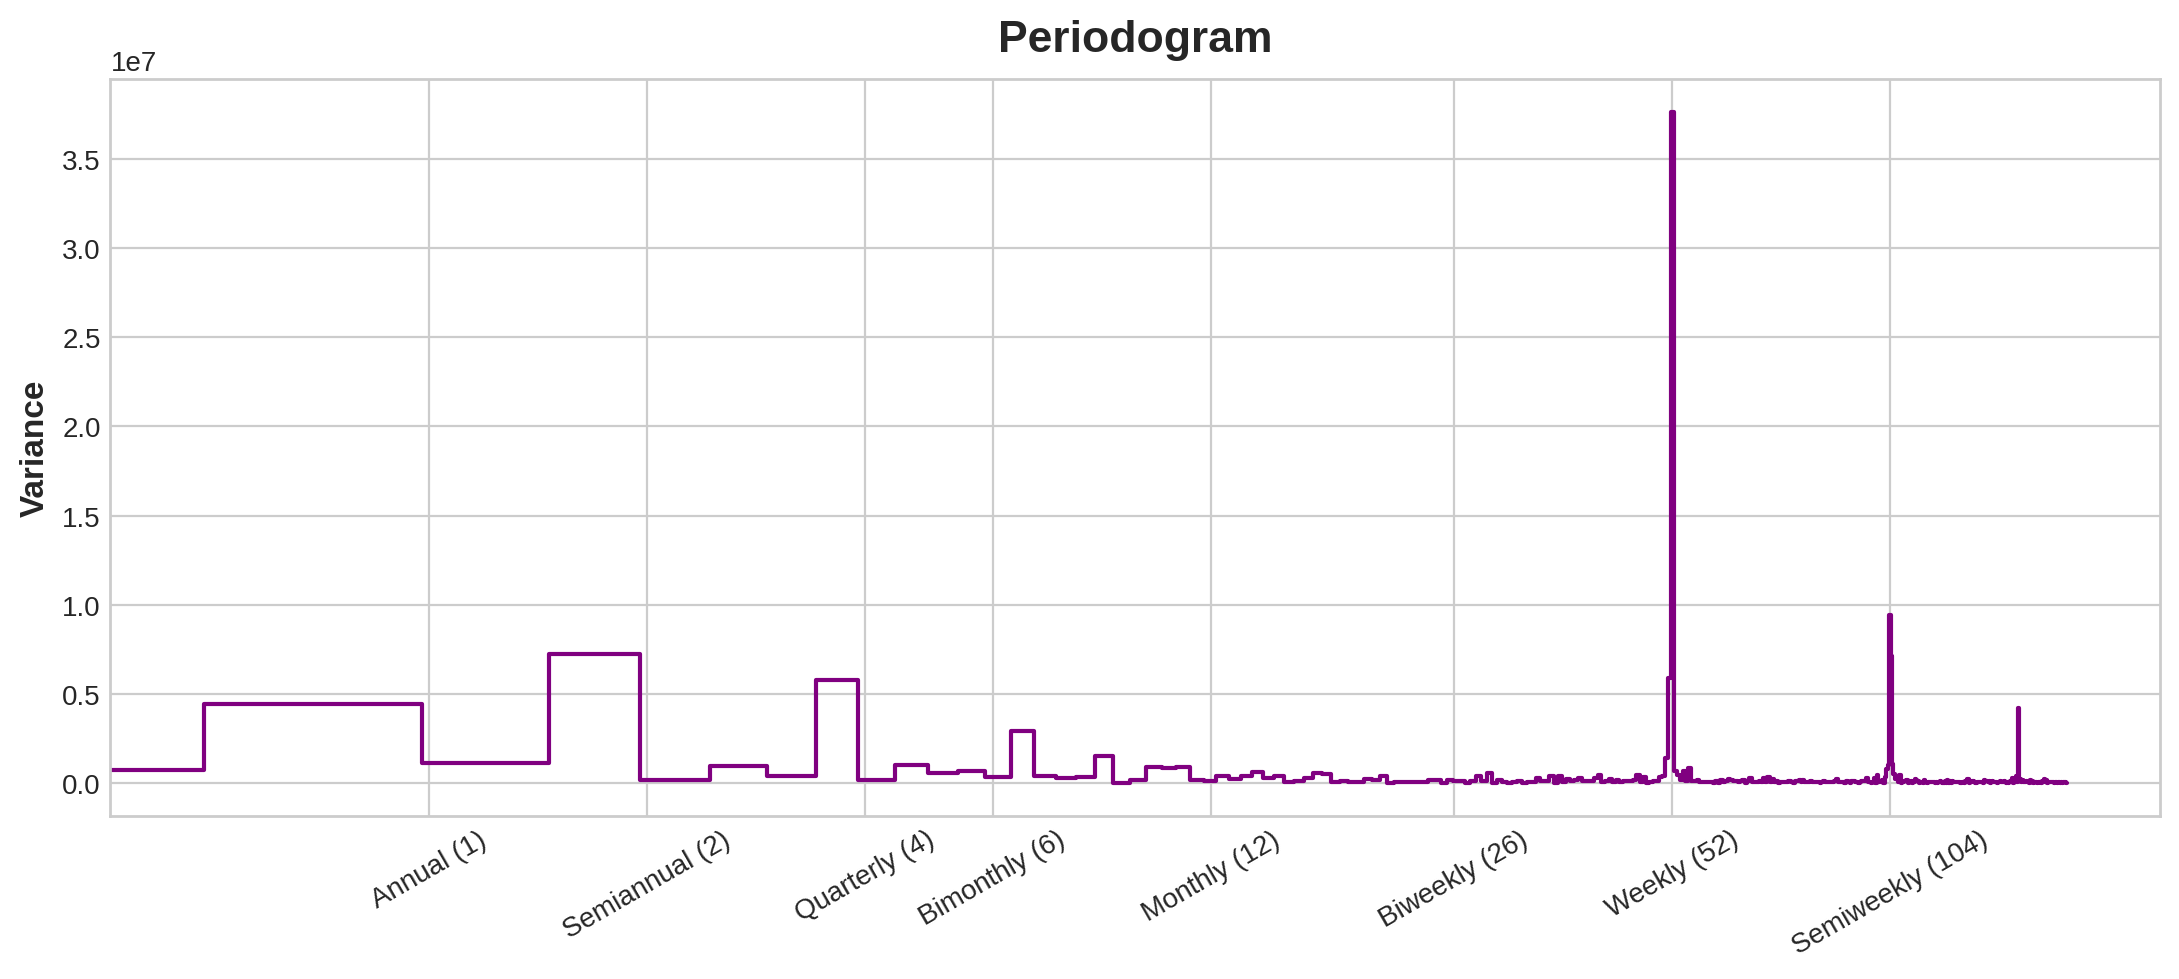

In [8]:
ax,frequencies=plot_periodogram(tunnel.NumVehicles)

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bi-monthly (6) and Monthly (12), which suggests significant periodic component with frequency in that range.

That's why, we use "10" Fourier pairs (10 combination of sine/cos functions with different freq.).

## **Deterministic Process:**

In [20]:
# CalendarFourier: create Fourier terms for modeling calendar effects in time series analysis,
# 10 sin/cos pairs for "Annual" seasonality
fourier = CalendarFourier(freq="A", order=10) #annual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
X.head(5)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


## **Linear Regression:**

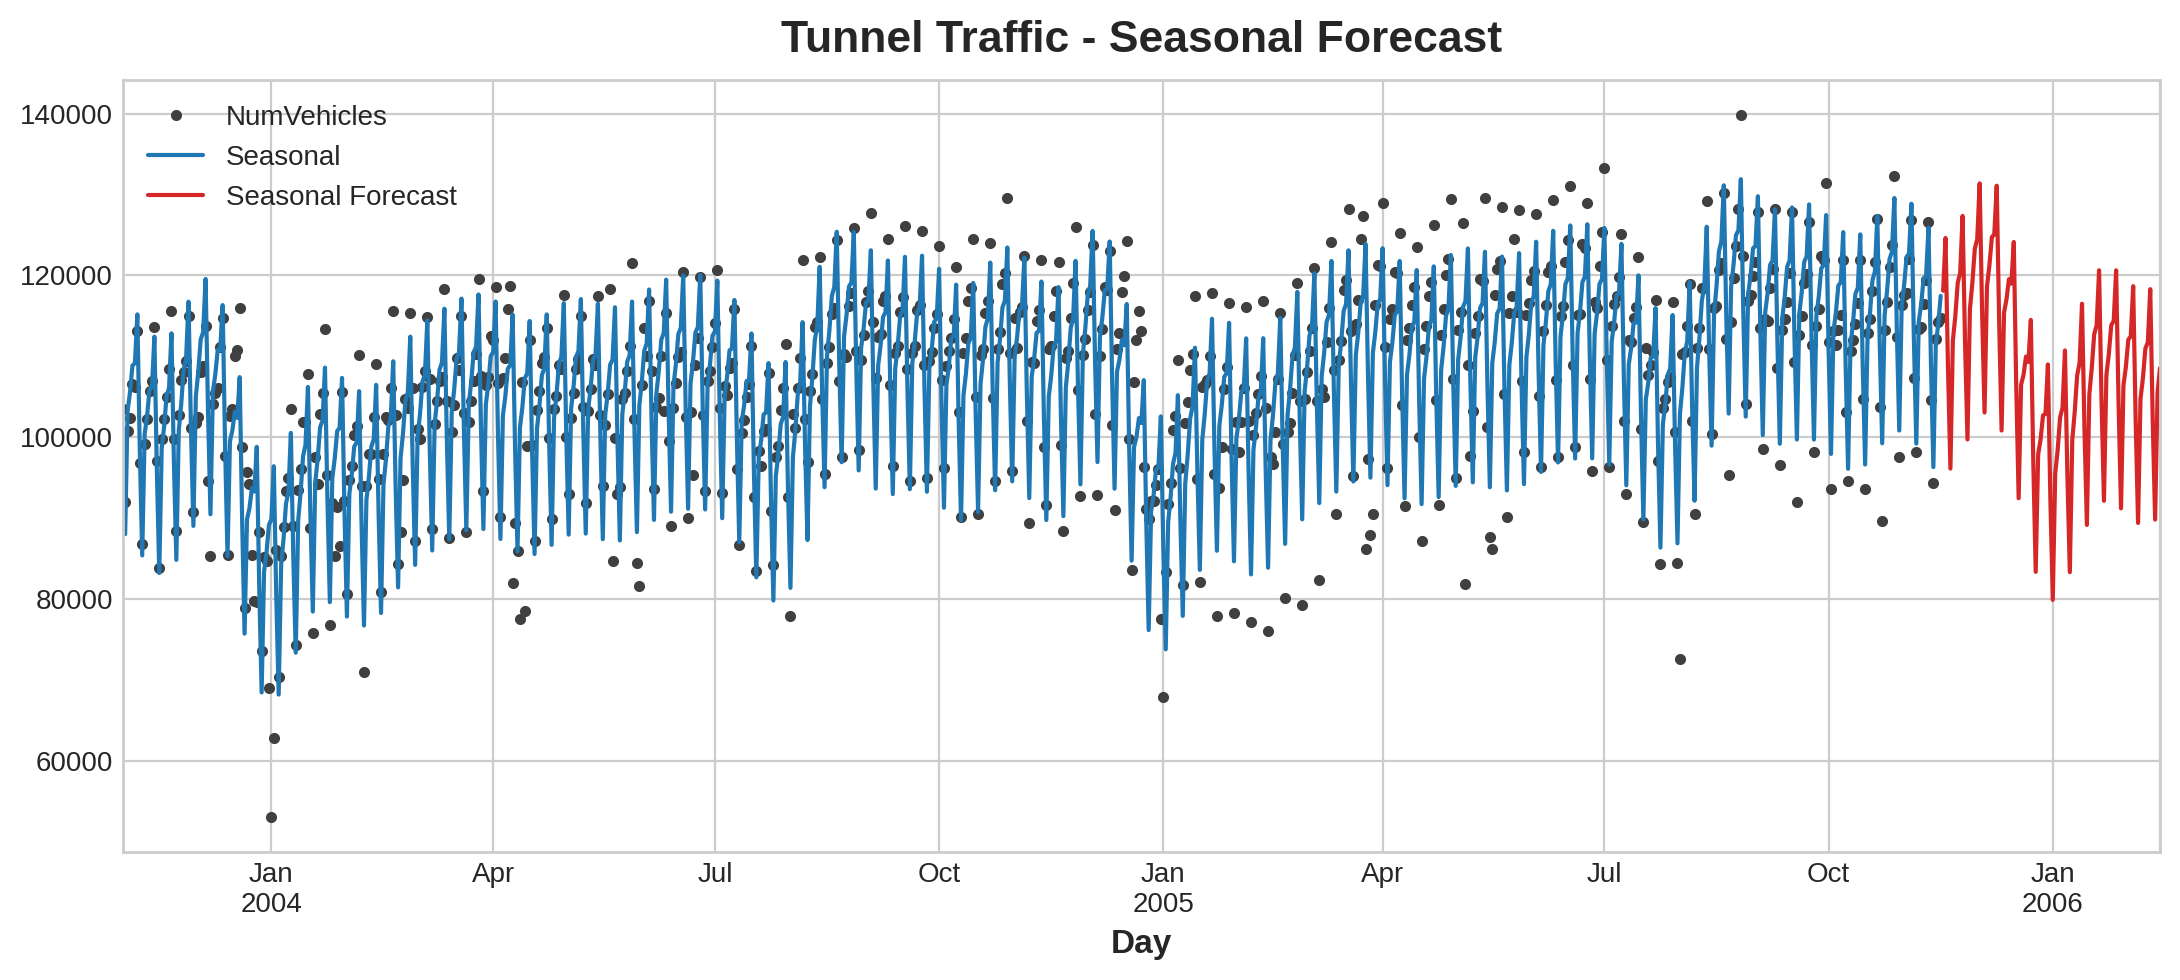

In [12]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()